### Imports

In [1]:
cd ..

c:\Users\seand\OneDrive\Dokumente\Masterthesis\StarBoundaryNetworks\src


In [2]:
import torch
from torch.autograd.functional import hessian
from torch import nn
from tqdm import tqdm

from domains.starDomain import Sphere
#from radialFunctions.radialFunctions import linearRadial, squaredRadial
from pdeOperators.operators import *
from lossFuncitons.pinnLossFunctions import *
from lossFuncitons.pinnNeuralOperatorLoss import *
from neuralOperators.imposedBCNeuralOperator import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
from scipy.interpolate import griddata
from ipywidgets import *
import numpy as np
import copy
#%matplotlib notebook
%matplotlib widget

Problem is defined in the following way. Let $\Omega = B(0,1)$ be the open Ball with center at 0 and radius 1.
We want to find the solution of 

$\Delta u = 0, ~ \text{on } \Omega $ and 

$ u = f, \text{ on } \partial \Omega $

For some $f \in C( \partial \Omega )$

### Define some evaluation functions for which we know the analytic solution of the equation above

In [3]:
#these are some harmonic functions

def testFunc1(xy_grid):
    x1 = xy_grid[0]
    x2 = xy_grid[1]
    return (torch.exp(x1)*torch.sin(x2)).view(-1,1)

def testFunc2(xy_grid):
    #this has a singularity at 0
    x1 = xy_grid[0]
    x2 = xy_grid[1]
    return (torch.log(x1*x1 + x2*x2)).view(-1,1)

def testFunc3(xy_grid):
    x1 = xy_grid[0]
    x2 = xy_grid[1]
    return (x1*x1 - x2*x2).view(-1,1)

def trainFunc(xy_grid,a,b,c):
    return a*testFunc1(xy_grid) + b*testFunc2(xy_grid) + c*testFunc3(xy_grid)

### Set Device

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Generate Domain and Data Points on ball and on boundary

In [5]:
#generate Points for training
domain  = Sphere(2,torch.tensor([2.,2.]), torch.tensor(1.),device)
ballPoints = domain.generateCartesianRandomPointsFullDomain(2000)
#bdPoints = domain.generateSphericalRandomPointsOnBoundary(1000)

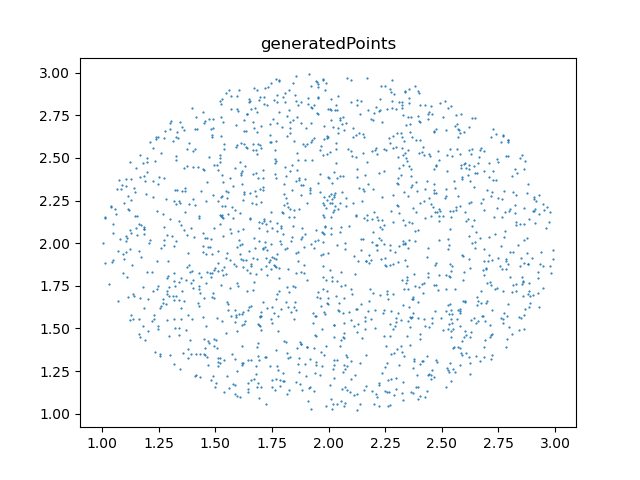

In [6]:
#plot generated points
pointsAsOneTensor = torch.cat(ballPoints, dim= 1).to("cpu")
fig1 = plt.figure()
ax1 = fig1.add_subplot(1,1,1)
ax1.set_title('generatedPoints')
ax1.scatter(pointsAsOneTensor[:,0],pointsAsOneTensor[:,1],s = 0.3)
plt.show()

### Define Model

In [7]:
createNewModel = False

if createNewModel:
    solOperator = ImposedBCDeepONetSphere2D(    n_hidden_trunk = 500,
                                                n_layers_trunk = 2,
                                                n_hidden_branch = 500,
                                                n_layers_branch = 3,
                                                domain = domain,
                                                nBoundaryPoints = 500
                                                )
else:
    solOperator= torch.load("./trainedModels/laplaceDeepONet.pt")


### Setting for Training

In [8]:
xy_grid = ballPoints
xy_grid[0].requires_grad = True
xy_grid[1].requires_grad = True
epochs = 1000
learningRate  = 5e-4
boundaryFunctionBatchSize = 50

In [9]:
#move everything to right device
xy_grid[0].to(device)
xy_grid[1].to(device)
solOperator.updateDevice(device)

In [10]:
#define optimizer
optimizer = torch.optim.Adam(solOperator.parameters(), lr = learningRate)

In [20]:
#computes initial loss to see where we start
loss = laplaceEquationLossOperator(solOperator, xy_grid, lambda grid : trainFunc(grid,1,1,1), device )
minLoss = loss.item()
loss

tensor(10.2623, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)

### Trainig

In [12]:
#training
for i in range(epochs):
    optimizer.zero_grad()
    #add loss of 20 rdm generated funcitons
    aRand,bRand, cRand = torch.rand(3)*2
    loss = laplaceEquationLossOperator(solOperator, xy_grid, lambda xy_grid : trainFunc(xy_grid,aRand,bRand,cRand), device = device )
    for funcIdx in range(boundaryFunctionBatchSize - 1):
        aRand,bRand, cRand = torch.rand(3) *2
        loss = loss + laplaceEquationLossOperator(solOperator, xy_grid, lambda xy_grid : trainFunc(xy_grid,aRand,bRand,cRand), device = device )
    loss = loss / boundaryFunctionBatchSize
    if loss.item() < minLoss:
        minLoss = loss.item()
        torch.save(solOperator, "./trainedModels/laplaceDeepONet.pt")
    if i%1 == 0:
        print(loss.item())
    loss.backward(retain_graph=True)
    optimizer.step()

9.626348974252688
28.521040746433197
18.79871829722081
13.401599370035294
17.57239402908672
22.529806199775408
14.273078113349355
14.745215880486844
13.491543655506609
12.763404046133969
13.73516221440653
10.615879500729344
12.223731109799573
13.58489273788585
12.078179987158713
12.422845356920993
11.413264789783423
13.219614854828041
12.250517770601558
12.896625212960982
10.257046763558428
11.5038593362657
12.821293604447831
11.421144248259345
9.370185511490842
13.569313235633473
12.426740378953648
13.411997740319471
16.007959316253324
11.911700210416603
13.280577173308993
13.218352808247532
14.159985854710667
12.682954177676839
11.807190116313043
12.615995252779507
12.481643586789595
12.703864857176864
11.948780287622244
10.16490728388139
12.777312581115883
11.199818558012899
12.031062769947471
13.232139159194258
12.844374829462259
11.675629431334672
11.618872508111318
11.008537881885388
10.482296422016045
12.808359590702565
11.40785636034895
11.298328967271818
13.156591492122605
11.

KeyboardInterrupt: 

In [ ]:
#torch.save(solOperator.state_dict(), "./trainedModels/laplaceDeepONet.pt")

### Visualize

#### First Test Function

In [46]:
#test with first test function:
neuralOpOut1 = solOperator(xy_grid, testFunc1)
loss1 = laplacian(neuralOpOut1, xy_grid, device = device).to("cpu")

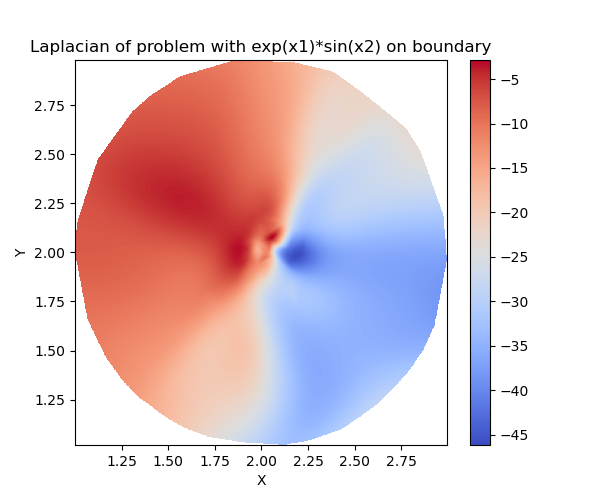

In [47]:
# Plot losses on training data points as heatmap

sampleSizeForDrawing = min(1000, xy_grid[0].shape[0])
data = np.empty((sampleSizeForDrawing,3))
data[:,0] = xy_grid[0][:sampleSizeForDrawing].to("cpu").view(-1).detach().numpy()
data[:,1] = xy_grid[1][:sampleSizeForDrawing].to("cpu").view(-1).detach().numpy()
data[:,2] = loss1[:sampleSizeForDrawing].view(-1).detach().numpy()

# Create a meshgrid to interpolate over (choose grid resolution as needed)
grid_x, grid_y = np.mgrid[min(data[:, 0]):max(data[:, 0]):1000j, 
                          min(data[:, 1]):max(data[:, 1]):1000j]

# Interpolate the z values over the grid
grid_z = griddata((data[:, 0], data[:, 1]), data[:, 2], (grid_x, grid_y), method='cubic')



# Plot the heatmap
plt.figure(figsize=(6, 5))
plt.pcolormesh(grid_x, grid_y, grid_z, cmap='coolwarm', shading='auto')
plt.colorbar()  # Add colorbar to the side
plt.title("Laplacian of problem with exp(x1)*sin(x2) on boundary")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

C:\Users\seand\AppData\Local\Temp\ipykernel_19312\2720754531.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax6.scatter(x, y, z, cmap='viridis',c = 'blue')
C:\Users\seand\AppData\Local\Temp\ipykernel_19312\2720754531.py:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax6.scatter(x,y,ztrue, cmap = 'viridis', c = 'red' )


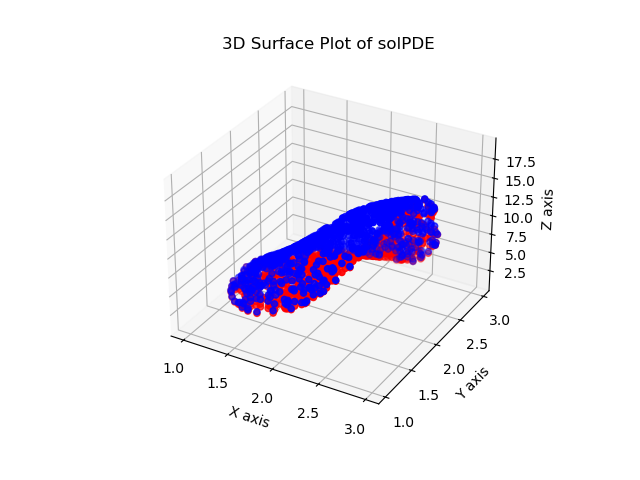

In [48]:
numPointsPlot = min(1000, xy_grid[0].shape[0])
x = xy_grid[0][:numPointsPlot].to("cpu").view(-1).detach().numpy()
y = xy_grid[1][:numPointsPlot].to("cpu").view(-1).detach().numpy()


ztrue = testFunc1([xy_grid[0][:numPointsPlot] , xy_grid[1][:numPointsPlot]] ).to("cpu").view(-1).detach().numpy()



z = neuralOpOut1[:numPointsPlot].to("cpu").view(-1).detach().numpy()

# Create a 3D plot
fig6 = plt.figure()
ax6 = fig6.add_subplot(111, projection='3d')

# Plot the surface
ax6.scatter(x, y, z, cmap='viridis',c = 'blue')
ax6.scatter(x,y,ztrue, cmap = 'viridis', c = 'red' )

# Add labels and title
ax6.set_xlabel('X axis')
ax6.set_ylabel('Y axis')
ax6.set_zlabel('Z axis')
ax6.set_title('3D Surface Plot of solPDE')

# Show plot
plt.show()

#### Second Test Function

In [52]:
#test with second test function:
neuralOpOut2 = solOperator(xy_grid, testFunc2)
loss2 = laplacian(neuralOpOut2, xy_grid, device = device).to("cpu")

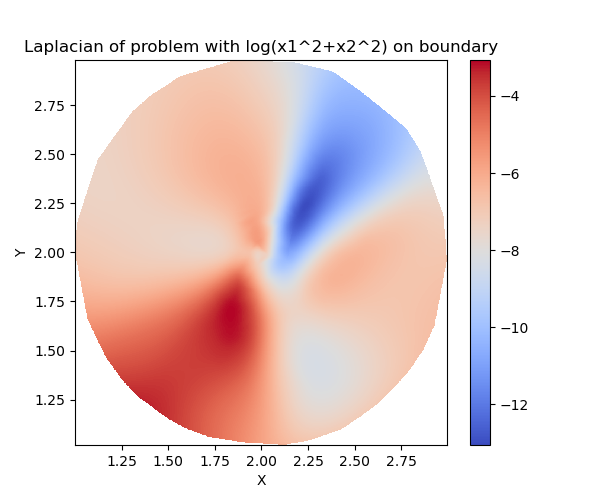

In [53]:
# Plot losses on training data points as heatmap

sampleSizeForDrawing = min(1000, xy_grid[0].shape[0])
data = np.empty((sampleSizeForDrawing,3))
data[:,0] = xy_grid[0][:sampleSizeForDrawing].to("cpu").view(-1).detach().numpy()
data[:,1] = xy_grid[1][:sampleSizeForDrawing].to("cpu").view(-1).detach().numpy()
data[:,2] = loss2[:sampleSizeForDrawing].view(-1).detach().numpy()

# Create a meshgrid to interpolate over (choose grid resolution as needed)
grid_x, grid_y = np.mgrid[min(data[:, 0]):max(data[:, 0]):1000j, 
                          min(data[:, 1]):max(data[:, 1]):1000j]

# Interpolate the z values over the grid
grid_z = griddata((data[:, 0], data[:, 1]), data[:, 2], (grid_x, grid_y), method='cubic')



# Plot the heatmap
plt.figure(figsize=(6, 5))
plt.pcolormesh(grid_x, grid_y, grid_z, cmap='coolwarm', shading='auto')
plt.colorbar()  # Add colorbar to the side
plt.title("Laplacian of problem with log(x1^2+x2^2) on boundary")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

C:\Users\seand\AppData\Local\Temp\ipykernel_19312\502291267.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax6.scatter(x, y, z, cmap='viridis',c = 'blue')
C:\Users\seand\AppData\Local\Temp\ipykernel_19312\502291267.py:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax6.scatter(x,y,ztrue, cmap = 'viridis', c = 'red' )


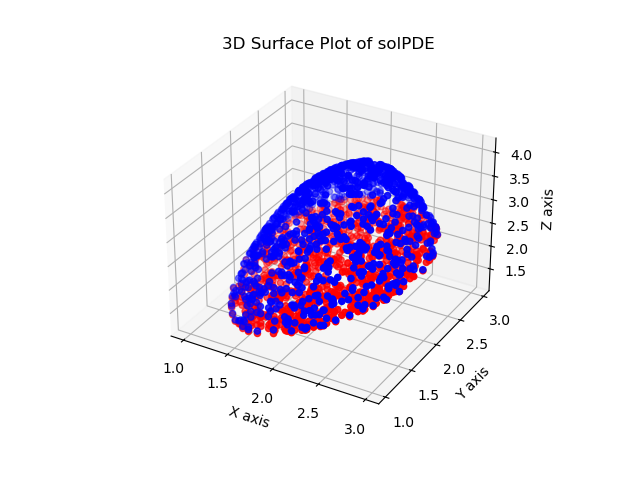

In [54]:
numPointsPlot = min(1000, xy_grid[0].shape[0])
x = xy_grid[0][:numPointsPlot].to("cpu").view(-1).detach().numpy()
y = xy_grid[1][:numPointsPlot].to("cpu").view(-1).detach().numpy()


ztrue = testFunc2([xy_grid[0][:numPointsPlot],xy_grid[1][:numPointsPlot]]).to("cpu").view(-1).detach().numpy()



z = neuralOpOut2[:numPointsPlot].to("cpu").view(-1).detach().numpy()

# Create a 3D plot
fig6 = plt.figure()
ax6 = fig6.add_subplot(111, projection='3d')

# Plot the surface
ax6.scatter(x, y, z, cmap='viridis',c = 'blue')
ax6.scatter(x,y,ztrue, cmap = 'viridis', c = 'red' )

# Add labels and title
ax6.set_xlabel('X axis')
ax6.set_ylabel('Y axis')
ax6.set_zlabel('Z axis')
ax6.set_title('3D Surface Plot of solPDE')

# Show plot
plt.show()

#### Third Test Function

In [55]:
#test with third test function:
neuralOpOut3 = solOperator(xy_grid, testFunc3)
loss3 = laplacian(neuralOpOut3, xy_grid, device= device).to("cpu")

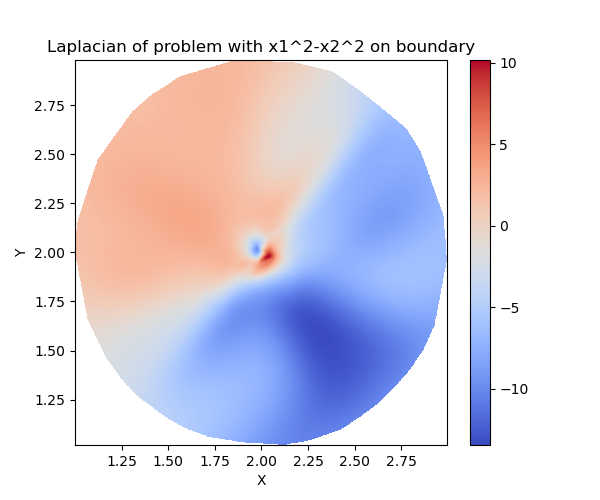

In [56]:
# Plot losses on training data points as heatmap

sampleSizeForDrawing = min(1000, xy_grid[0].shape[0])
data = np.empty((sampleSizeForDrawing,3))
data[:,0] = xy_grid[0][:sampleSizeForDrawing].to("cpu").view(-1).detach().numpy()
data[:,1] = xy_grid[1][:sampleSizeForDrawing].to("cpu").view(-1).detach().numpy()
data[:,2] = loss3[:sampleSizeForDrawing].view(-1).detach().numpy()

# Create a meshgrid to interpolate over (choose grid resolution as needed)
grid_x, grid_y = np.mgrid[min(data[:, 0]):max(data[:, 0]):1000j, 
                          min(data[:, 1]):max(data[:, 1]):1000j]

# Interpolate the z values over the grid
grid_z = griddata((data[:, 0], data[:, 1]), data[:, 2], (grid_x, grid_y), method='cubic')



# Plot the heatmap
plt.figure(figsize=(6, 5))
plt.pcolormesh(grid_x, grid_y, grid_z, cmap='coolwarm', shading='auto')
plt.colorbar()  # Add colorbar to the side
plt.title("Laplacian of problem with x1^2-x2^2 on boundary")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

C:\Users\seand\AppData\Local\Temp\ipykernel_19312\1343100149.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax6.scatter(x, y, z, cmap='viridis',c = 'blue')
C:\Users\seand\AppData\Local\Temp\ipykernel_19312\1343100149.py:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax6.scatter(x,y,ztrue, cmap = 'viridis', c = 'red' )


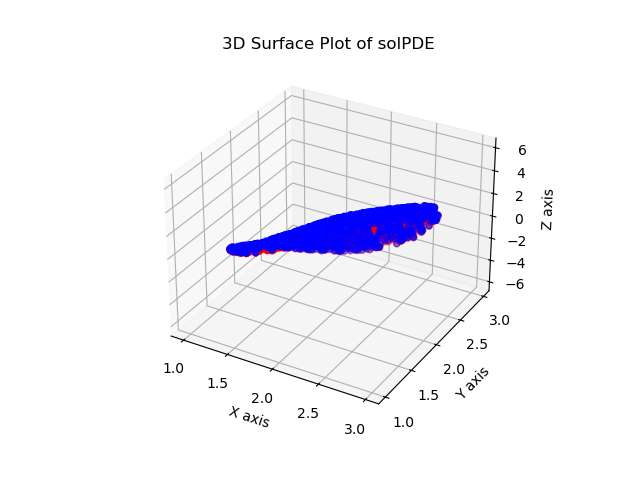

In [57]:
numPointsPlot = min(1000, xy_grid[0].shape[0])
x = xy_grid[0][:numPointsPlot].to("cpu").view(-1).detach().numpy()
y = xy_grid[1][:numPointsPlot].to("cpu").view(-1).detach().numpy()


ztrue = testFunc3([xy_grid[0][:numPointsPlot], xy_grid[1][:numPointsPlot]]).to("cpu").view(-1).detach().numpy()



z = neuralOpOut3[:numPointsPlot].to("cpu").view(-1).detach().numpy()

# Create a 3D plot
fig6 = plt.figure()
ax6 = fig6.add_subplot(111, projection='3d')

# Plot the surface
ax6.scatter(x, y, z, cmap='viridis',c = 'blue')
ax6.scatter(x,y,ztrue, cmap = 'viridis', c = 'red' )

# Add labels and title
ax6.set_xlabel('X axis')
ax6.set_ylabel('Y axis')
ax6.set_zlabel('Z axis')
ax6.set_title('3D Surface Plot of solPDE')

# Show plot
plt.show()

#### Mix of Test Functions

In [59]:
#test with mix test function:
coeffs = [0,1,0] 
neuralOpOutMix = solOperator(xy_grid, lambda grid : trainFunc(grid,coeffs[0],coeffs[1],coeffs[2]))
lossMix = laplacian(neuralOpOutMix, xy_grid, device= device).to("cpu")

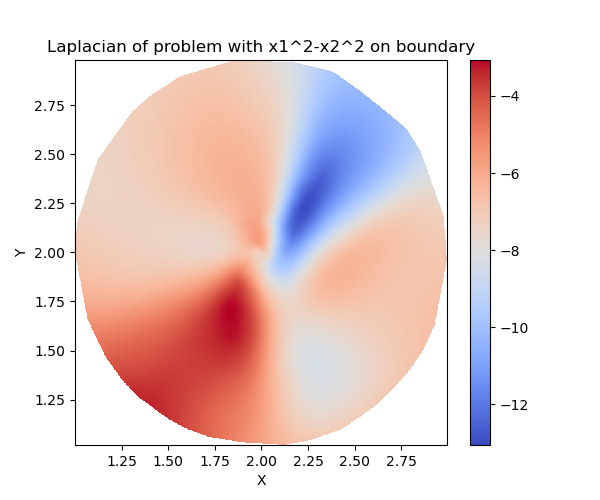

In [60]:
# Plot losses on training data points as heatmap

sampleSizeForDrawing = min(1000, xy_grid[0].shape[0])
data = np.empty((sampleSizeForDrawing,3))
data[:,0] = xy_grid[0][:sampleSizeForDrawing].to("cpu").view(-1).detach().numpy()
data[:,1] = xy_grid[1][:sampleSizeForDrawing].to("cpu").view(-1).detach().numpy()
data[:,2] = lossMix[:sampleSizeForDrawing].view(-1).detach().numpy()

# Create a meshgrid to interpolate over (choose grid resolution as needed)
grid_x, grid_y = np.mgrid[min(data[:, 0]):max(data[:, 0]):1000j, 
                          min(data[:, 1]):max(data[:, 1]):1000j]

# Interpolate the z values over the grid
grid_z = griddata((data[:, 0], data[:, 1]), data[:, 2], (grid_x, grid_y), method='cubic')



# Plot the heatmap
plt.figure(figsize=(6, 5))
plt.pcolormesh(grid_x, grid_y, grid_z, cmap='coolwarm', shading='auto')
plt.colorbar()  # Add colorbar to the side
plt.title("Laplacian of problem with x1^2-x2^2 on boundary")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

C:\Users\seand\AppData\Local\Temp\ipykernel_19312\294058642.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax6.scatter(x, y, z, cmap='viridis',c = 'blue')
C:\Users\seand\AppData\Local\Temp\ipykernel_19312\294058642.py:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax6.scatter(x,y,ztrue, cmap = 'viridis', c = 'red' )


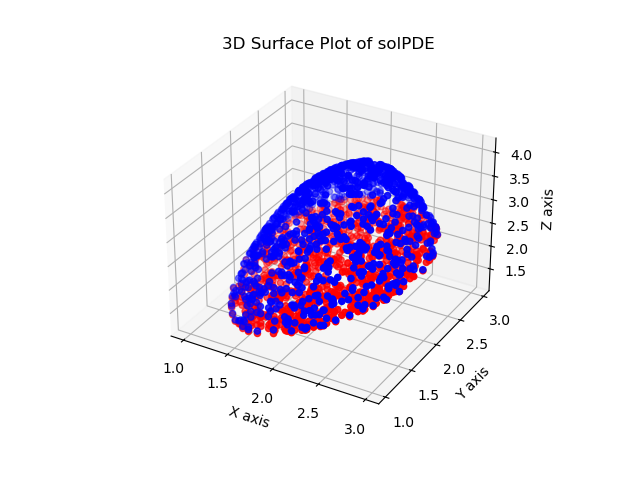

In [61]:
numPointsPlot = min(1000, xy_grid[0].shape[0])
x = xy_grid[0][:numPointsPlot].to("cpu").view(-1).detach().numpy()
y = xy_grid[1][:numPointsPlot].to("cpu").view(-1).detach().numpy()


ztrue = trainFunc([xy_grid[0][:numPointsPlot], xy_grid[1][:numPointsPlot]],coeffs[0],coeffs[1],coeffs[2]).to("cpu").view(-1).detach().numpy()



z = neuralOpOutMix[:numPointsPlot].to("cpu").view(-1).detach().numpy()

# Create a 3D plot
fig6 = plt.figure()
ax6 = fig6.add_subplot(111, projection='3d')

# Plot the surface
ax6.scatter(x, y, z, cmap='viridis',c = 'blue')
ax6.scatter(x,y,ztrue, cmap = 'viridis', c = 'red' )

# Add labels and title
ax6.set_xlabel('X axis')
ax6.set_ylabel('Y axis')
ax6.set_zlabel('Z axis')
ax6.set_title('3D Surface Plot of solPDE')

# Show plot
plt.show()